In [2]:
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torch.nn import functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, random_split, DataLoader

import os
import copy
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw

torch.manual_seed(0)
np.random.seed(0)

In [3]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [4]:
train_labels = './Data/train_labels.csv'
train_images = './Data/train/'
test_images = './Data/test/'

In [5]:
labels_df = pd.read_csv(train_labels)
labels_df.head()


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

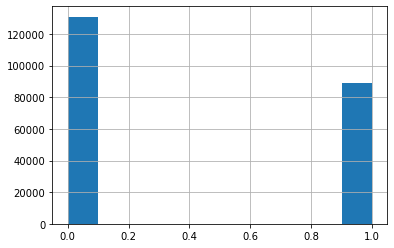

In [6]:
labels_df['label'].hist()

In [7]:
malignant_ids = labels_df.loc[labels_df['label']==1]['id'].values
print(f'Malignant: {malignant_ids}')

normal_ids = labels_df.loc[labels_df['label']==0]['id'].values
print(f'Normal: {normal_ids}')

Malignant: ['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f' ...
 '309210db7f424edbc22b2d13bf2fa27518b18f5c'
 'd4b854fe38b07fe2831ad73892b3cec877689576'
 'a81f84895ddcd522302ddf34be02eb1b3e5af1cb']
Normal: ['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' ...
 '53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6'
 '3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75'
 'f129691c13433f66e1e0671ff1fe80944816f5a2']


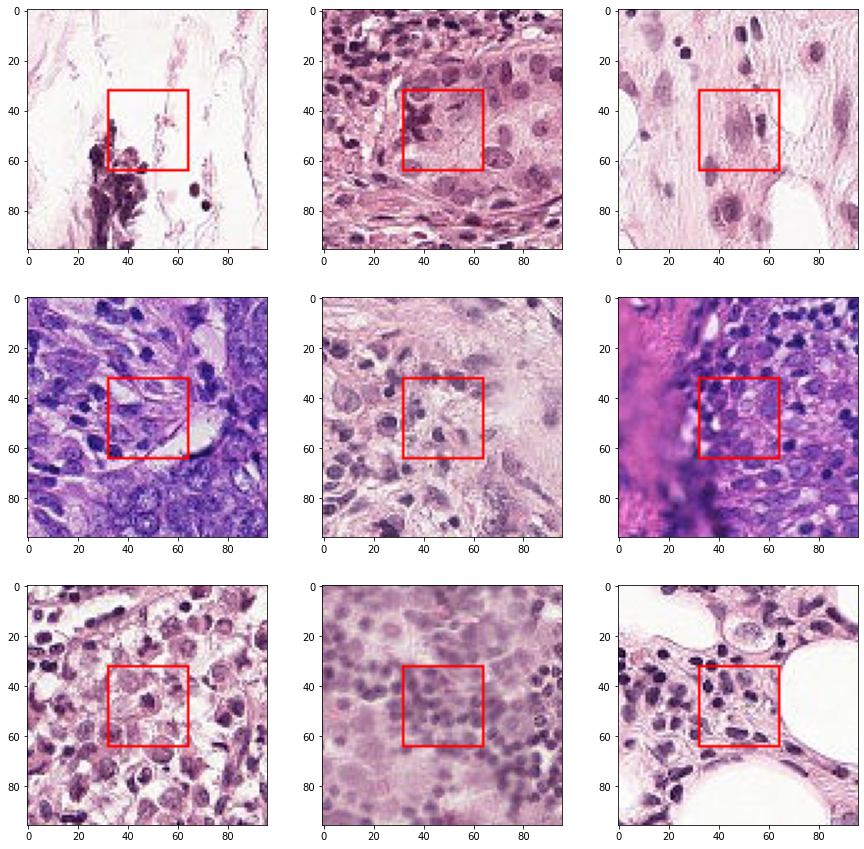

In [8]:
plt.rcParams['figure.figsize'] = (15., 15.)

for m_index, m_id in enumerate(malignant_ids[:9]):
    path = os.path.join(train_images, m_id + '.tif')
    img = Image.open(path)

    draw = ImageDraw.Draw(img)
    draw.rectangle(xy=((32, 32), (64, 64)), outline='red')

    plt.subplot(3, 3, m_index + 1)
    plt.imshow(np.array(img))

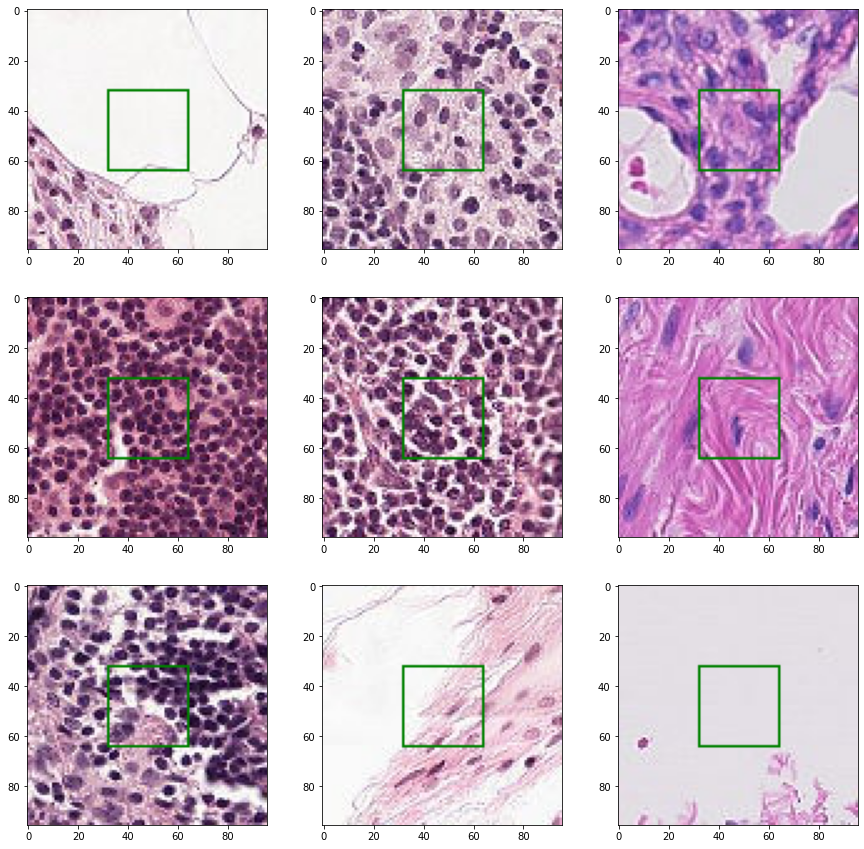

In [9]:
for n_index, n_id in enumerate(normal_ids[:9]):
    path = os.path.join(train_images, n_id + '.tif')
    img = Image.open(path)

    draw = ImageDraw.Draw(img)
    draw.rectangle(xy=((32, 32), (64, 64)), outline='green')

    plt.subplot(3, 3, n_index + 1)
    plt.imshow(np.array(img))

plt.show()

In [10]:
np.array(img).shape

(96, 96, 3)

In [11]:
class CancerDataset(Dataset):
    def __init__(self, transform, path, type='train'):
        path = os.path.join(path, type)
        filenames = os.listdir(path)
        self.full_filenames = [os.path.join(path, file) for file in filenames]

        labels_df = pd.read_csv(train_labels)
        labels_df.set_index('id', inplace=True)

        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)

        return image, self.labels[idx]

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
data_path = './Data/'
dataset = CancerDataset(transform, data_path, 'train')


In [14]:
print(len(dataset))
print(dataset.__getitem__(0))

220025
(tensor([[[0.9725, 0.9176, 0.7647,  ..., 0.8824, 0.7569, 0.9255],
         [0.7569, 1.0000, 0.6353,  ..., 0.7451, 0.9725, 0.8980],
         [0.5529, 1.0000, 0.6353,  ..., 0.8588, 0.8157, 0.7608],
         ...,
         [0.4863, 0.6706, 0.8824,  ..., 0.7294, 0.7490, 0.7804],
         [0.3804, 0.3647, 0.5961,  ..., 0.7608, 0.8157, 0.7922],
         [0.2941, 0.4118, 0.7529,  ..., 0.7176, 0.8588, 0.5804]],

        [[0.7176, 0.6549, 0.5020,  ..., 0.6588, 0.4902, 0.6314],
         [0.5255, 0.8745, 0.3961,  ..., 0.5137, 0.7176, 0.6078],
         [0.3569, 0.8549, 0.4196,  ..., 0.6157, 0.5569, 0.4863],
         ...,
         [0.2275, 0.3961, 0.5922,  ..., 0.4667, 0.4863, 0.5176],
         [0.1569, 0.1216, 0.3216,  ..., 0.4824, 0.5412, 0.5137],
         [0.0902, 0.1922, 0.4980,  ..., 0.4275, 0.5765, 0.3020]],

        [[0.8353, 0.7765, 0.6235,  ..., 0.7333, 0.5804, 0.7216],
         [0.6353, 0.9843, 0.5176,  ..., 0.6000, 0.8039, 0.7059],
         [0.4549, 0.9647, 0.5333,  ..., 0.7137, 0.

torch.Size([3, 96, 96])


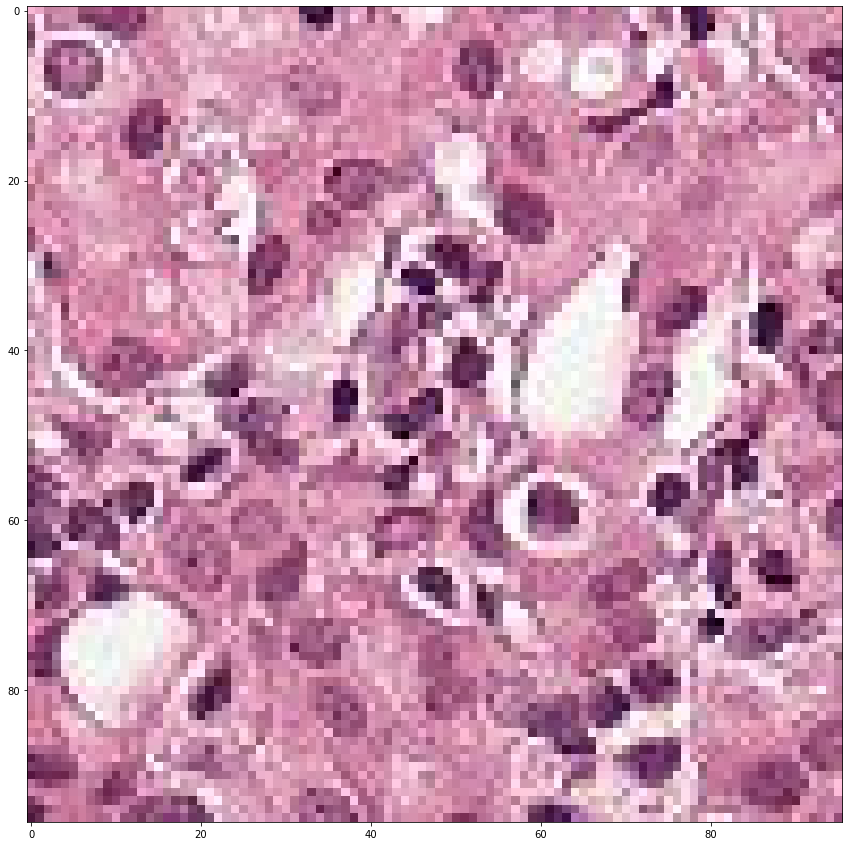

In [15]:
img, _ = dataset[0]
print(img.shape)
plt.imshow(np.array(img).transpose(1,2,0))

In [16]:
train_dataset, val_dataset = random_split(dataset, [int(0.8 * len(dataset)), int(0.2 * len(dataset))])

In [17]:
print(f'train ds: {len(train_dataset)}')
print(f'val ds: {len(val_dataset)}')

train ds: 176020
val ds: 44005


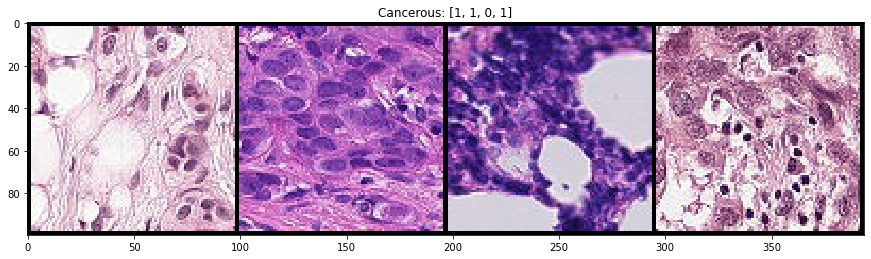

In [18]:
def show_img(img, labels):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img, interpolation='nearest')
    plt.title(f'Cancerous: {labels}')

rand_i = np.random.randint(0, len(train_dataset), 4)
imgs = [train_dataset[i][0] for i in rand_i]
labels = [train_dataset[i][1] for i in rand_i]

imgs = utils.make_grid(imgs, nrow=4)
plt.rcParams['figure.figsize'] = (15.0, 5)
show_img(imgs, labels)

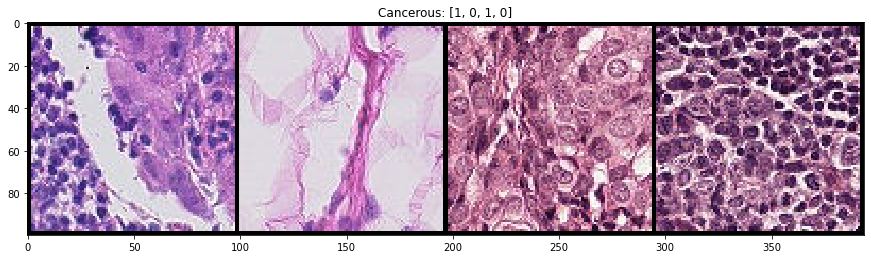

In [19]:
rand_i = np.random.randint(0, len(val_dataset), 4)

imgs = utils.make_grid([val_dataset[i][0] for i in rand_i], nrow=4)
labels = [val_dataset[i][1] for i in rand_i]
show_img(imgs, labels)

In [20]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.5)
    , transforms.RandomVerticalFlip(p=.5)
    , transforms.RandomRotation(45)
    , transforms.RandomResizedCrop(96, (0.8, 1.0), ratio=(1., 1.))
    , transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
# train_dataset.transform = train_transform
# val_dataset.transform = val_transform

train_dl = DataLoader(train_dataset, batch_size=hp['batch_size'], shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=hp['batch_size'], shuffle=False)

In [22]:
for x, _ in train_dl:
    x = list(x.shape)
    print(f'Batch size: {x[0]}, Channels: {x[1]}, Size: {x[2]}x{x[3]}')
    break

Batch size: 512, Channels: 3, Size: 96x96


In [23]:
# Used to calculate the output size of a conv layer.
def conv_size(h, w, conv: nn.Conv2d, pool=1):
    size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    h = np.floor((h + 2 * padding[0] - dilation[0] * (size[0] - 1) - 1) / stride[0] + 1) / pool
    w = np.floor((w + 2 * padding[1] - dilation[1] * (size[1] - 1) - 1) / stride[1] + 1) / pool

    return int(h), int(w)

test = nn.Conv2d(3, 8, kernel_size=3)
print(conv_size(96, 96, test))

(94, 94)


In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        C, H, W = hp['input_shape']

        out_1, kernel_1, stride_1, padding_1 = hp['conv1']
        out_2, kernel_2, stride_2, padding_2 = hp['conv2']
        out_3, kernel_3, stride_3, padding_3 = hp['conv3']
        out_4, kernel_4, stride_4, padding_4 = hp['conv4']
        out_5, kernel_5, stride_5, padding_5 = hp['conv5']

        linear1 = hp['linear1']
        linear2 = hp['linear2']
        classes = hp['classes']
        dropout = hp['dropout']

        self.conv1 = nn.Conv2d(C, out_1, kernel_size=kernel_1, stride=stride_1, padding=padding_1)
        self.conv2 = nn.Conv2d(out_1, out_2, kernel_size=kernel_2, stride=stride_2, padding=padding_2)
        self.conv3 = nn.Conv2d(out_2, out_3, kernel_size=kernel_3, stride=stride_3, padding=padding_3)
        self.conv4 = nn.Conv2d(out_3, out_4, kernel_size=kernel_4, stride=stride_4, padding=padding_4)
        self.conv5 = nn.Conv2d(out_4, out_5, kernel_size=kernel_5, stride=stride_5, padding=padding_5)

        h, w = conv_size(H, W, self.conv1, pool=2)
        h, w = conv_size(h, w, self.conv2, pool=2)
        h, w = conv_size(h, w, self.conv3, pool=2)
        h, w = conv_size(h, w, self.conv4, pool=2)
        h, w = conv_size(h, w, self.conv5, pool=2)
        self.flat = h * w * out_5

        self.features = nn.Sequential(
            # block 1
            self.conv1
            , nn.BatchNorm2d(out_1)
            , nn.ReLU()
            , nn.MaxPool2d(2)

            # block 2
            , self.conv2
            , nn.BatchNorm2d(out_2)
            , nn.ReLU()
            , nn.MaxPool2d(2)

            # block 3
            , self.conv3
            , nn.BatchNorm2d(out_3)
            , nn.ReLU()
            , nn.MaxPool2d(2)

            # block 4
            , self.conv4
            , nn.BatchNorm2d(out_4)
            , nn.ReLU()
            , nn.MaxPool2d(2)

            # block 5
            , self.conv5
            , nn.BatchNorm2d(out_5)
            , nn.ReLU()
            , nn.MaxPool2d(2)

            , nn.Dropout2d()
        )

        self.classifier = nn.Sequential(
            # block 1
            nn.Linear(self.flat, linear1)
            , nn.BatchNorm1d(linear1)
            , nn.ReLU()
            , nn.Dropout(p=dropout)

            , nn.Linear(linear1, linear2)
            , nn.BatchNorm1d(linear2)
            , nn.ReLU()
            , nn.Dropout(p=dropout)

            # output
            , nn.Linear(linear2, classes)
            , nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.flat)
        x = self.classifier(x)
        return x

net = Net().cuda()

In [24]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(

In [25]:
summary(net, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
            Conv2d-2           [-1, 32, 96, 96]             896
       BatchNorm2d-3           [-1, 32, 96, 96]              64
              ReLU-4           [-1, 32, 96, 96]               0
         MaxPool2d-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 64, 48, 48]          18,496
            Conv2d-7           [-1, 64, 48, 48]          18,496
       BatchNorm2d-8           [-1, 64, 48, 48]             128
              ReLU-9           [-1, 64, 48, 48]               0
        MaxPool2d-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
           Conv2d-12          [-1, 128, 24, 24]          73,856
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14          [-1, 128,

C:\Users\Bill\anaconda3\envs\DeepLearning\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [26]:
for xb, yb in train_dl:
    print(yb)
    break

tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,

In [27]:
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=1)

In [28]:
def batch_accuracy(output: torch.Tensor, target: torch.Tensor):
    prediction = output.argmax(dim=1, keepdim=True)
    correct = prediction.eq(target.view_as(prediction)).sum().item()
    return correct

In [29]:
def batch_loss(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    with torch.no_grad():
        accuracy = batch_accuracy(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), accuracy

In [30]:
def epoch_loss(net, criterion, dataset, optimizer=None):
    total_loss = 0.
    total_acc = 0.

    for data, target in dataset:
        data = data.cuda()
        target = target.cuda()

        output = net(data)
        # target = target.float().unsqueeze(1)
        loss, acc = batch_loss(criterion, output, target, optimizer)
        total_loss += loss

        if acc is not None:
            total_acc += acc

    loss = total_loss / float(len(dataset.dataset))
    acc = total_acc / float(len(dataset.dataset))

    return loss, acc

In [31]:
# so jupyter doesn't mess my stuff up
params = {
    'epochs': hp['epochs'],
    'criterion': criterion,
    'optimizer': optimizer,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'scheduler': scheduler,
    'save_loc': './models/weights.pt',
}

history = {
    'train': {
        'loss': [],
        'acc': []
    },
    'val': {
        'loss': [],
        'acc': []
    }
}

def train(net, params):
    epochs = params['epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    scheduler = params['scheduler']
    save_loc = params['save_loc']
    weights = copy.deepcopy(net.state_dict())
    best_loss = float('inf')

    # train loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f'Train Epoch: {epoch + 1}/{epochs}\tLR: {lr}')

        # train
        net.train()
        loss_t, acc_t = epoch_loss(net, criterion, train_dl, optimizer)
        history['train']['loss'].append(loss_t)
        history['train']['acc'].append(acc_t)

        # eval
        net.eval()
        with torch.no_grad():
            loss_v, acc_v = epoch_loss(net, criterion, val_dl)
        history['val']['loss'].append(loss_v)
        history['val']['acc'].append(acc_v)

        if loss_v < best_loss:
            best_loss = loss_v
            weights = copy.deepcopy(net.state_dict())
            torch.save(weights, save_loc)
            print(f'Weights saved. Loss: {best_loss:.3f}')

        scheduler.step(loss_v)
        if lr != optimizer.param_groups[0]['lr']:
            net.load_state_dict(weights)
            print("Weights being loaded ...")

        print(f'Train loss: {loss_t:.3f}{" " * 5}Val loss: {loss_v:.3f}{" " * 5}Val acc: {acc_v * 100:.3f}')
        print('-' * 15)

    net.load_state_dict(weights)

    return net # trained model

In [32]:
trained_net = train(net, params)

Train Epoch: 1/40	LR: 0.0001
Weights saved. Loss: 0.311
Train loss: 0.379     Val loss: 0.311     Val acc: 86.690
---------------
Train Epoch: 2/40	LR: 0.0001
Weights saved. Loss: 0.299
Train loss: 0.296     Val loss: 0.299     Val acc: 87.390
---------------
Train Epoch: 3/40	LR: 0.0001
Weights saved. Loss: 0.248
Train loss: 0.256     Val loss: 0.248     Val acc: 89.860
---------------
Train Epoch: 4/40	LR: 0.0001
Weights saved. Loss: 0.214
Train loss: 0.229     Val loss: 0.214     Val acc: 91.390
---------------
Train Epoch: 5/40	LR: 0.0001
Train loss: 0.208     Val loss: 0.231     Val acc: 91.053
---------------
Train Epoch: 6/40	LR: 0.0001
Weights saved. Loss: 0.187
Train loss: 0.187     Val loss: 0.187     Val acc: 92.596
---------------
Train Epoch: 7/40	LR: 0.0001
Train loss: 0.177     Val loss: 0.204     Val acc: 92.090
---------------
Train Epoch: 8/40	LR: 0.0001
Train loss: 0.156     Val loss: 0.249     Val acc: 90.397
---------------
Train Epoch: 9/40	LR: 0.0001
Weights save

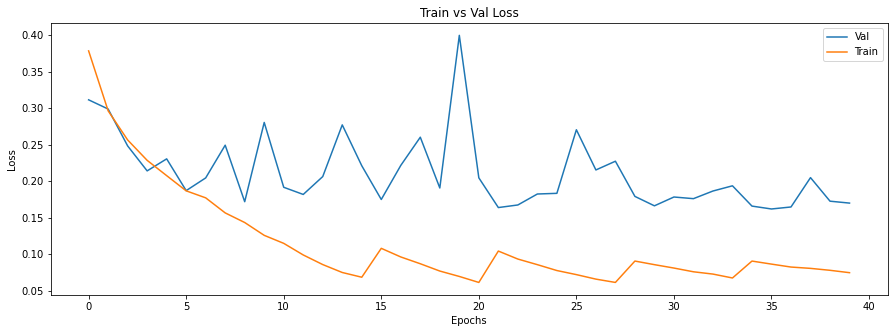

In [33]:
plt.clf()
plt.title('Train vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history['val']['loss'], label='Val')
plt.plot(history['train']['loss'], label='Train')
plt.legend()
plt.show()

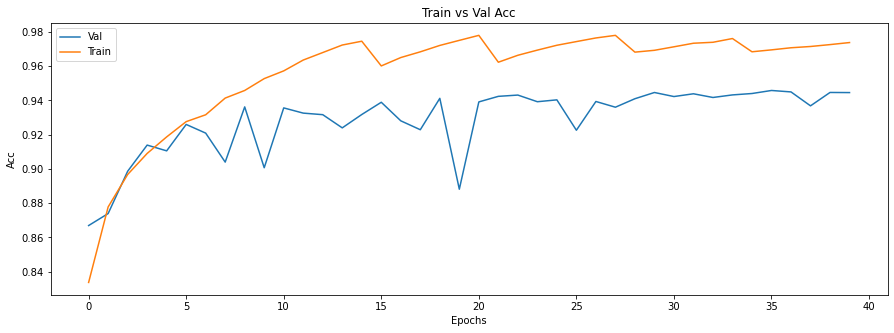

In [34]:
plt.clf()
plt.title('Train vs Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.plot(history['val']['acc'], label='Val')
plt.plot(history['train']['acc'], label='Train')
plt.legend()
plt.show()

In [53]:
net.load_state_dict(torch.load('./models/weights.pt'))

submission_df = pd.read_csv('./Data/sample_submission.csv')
submission_df.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [78]:
from torchvision.datasets import ImageFolder

test_files = os.listdir('./Data/test/')
net.eval()


for index, filename in enumerate(test_files):
    image = Image.open(f'./Data/test/{filename}')
    image = np.asarray(image)
    image = image.transpose((2, 0, 1))
    image = torch.Tensor(image).cuda().unsqueeze(0)
    out = net(image).argmax(dim=1, keepdim=True).item()
    submission_df.loc[index] = {
        'id': filename[:-4],
        'label': out
    }

tensor([[    0.0000, -3736.0259]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
                                         id  \
0  00006537328c33e284c973d7b39d340809f7271b   
1  0000ec92553fda4ce39889f9226ace43cae3364e   
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2   
3  000253dfaa0be9d0d100283b22284ab2f6b643f6   
4  000270442cc15af719583a8172c87cd2bd9c7746   

                                               label  
0  [[tensor(0., device='cuda:0', grad_fn=<SelectB...  
1                                                  0  
2                                                  0  
3                                                  0  
4                                                  0  


In [79]:
submission_df.reset_index(drop=True, inplace=True)

In [ ]:
submission_df.to_csv('submission.csv', index=False)